## Compute Sagnac Frequency - Backscatter Correction

## Imports

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read
from scipy.signal import hilbert


In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [4]:
config = {}

config['ring'] = "U"

config['seed'] = "BW.DROMY..FJU"

config['path_to_sds'] = archive_path+"romy_archive/"


config['tbeg'] = UTCDateTime("2023-09-01 17:00")
config['tend'] = UTCDateTime("2023-09-01 19:00")

# config['f_lower_zoomin'], config['f_upper_zoomin'] = 448-10, 448+10

## path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

In [5]:
def __load_romy_raw_data(seed, tbeg, tend, path_to_sds):

    from andbro__read_sds import __read_sds
    from obspy import Stream, UTCDateTime


    print(f" -> loading {seed}...")

    try:
        st00 = __read_sds(path_to_sds, seed, tbeg,tend, data_format='MSEED')
    except:
        print(f" -> failed for {seed}")

    st0 = st00.sort()

    for tr in st0:
        tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]

    return st0

### Load Local Files

In [6]:
# sagn = __load_romy_raw_data("BW.DROMY..FJU", config['tbeg'], config['tend'], config['path_to_sds'])
# mon1 = __load_romy_raw_data("BW.DROMY..F1V", config['tbeg'], config['tend'], config['path_to_sds'])
# mon2 = __load_romy_raw_data("BW.DROMY..F2V", config['tbeg'], config['tend'], config['path_to_sds'])


In [7]:
# sagn.write(root_path+"Downloads/mseed/DROMY_FJU_2023-09-01.mseed", format="MSEED")
# mon1.write(root_path+"Downloads/mseed/DROMY_F1V_2023-09-01.mseed", format="MSEED")
# mon2.write(root_path+"Downloads/mseed/DROMY_F2V_2023-09-01.mseed", format="MSEED")


In [8]:
sagn = read(root_path+"Downloads/mseed/DROMY_FJU_2023-09-01.mseed")
mon1 = read(root_path+"Downloads/mseed/DROMY_F1V_2023-09-01.mseed")
mon2 = read(root_path+"Downloads/mseed/DROMY_F2V_2023-09-01.mseed")

# # sagn.trim(config['tbeg'], config['tbeg']+1800)
# # mon1.trim(config['tbeg'], config['tbeg']+1800)
# # mon2.trim(config['tbeg'], config['tbeg']+1800)

for tr in sagn:
    tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]
for tr in mon1:
    tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]
for tr in mon2:
    tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]

# config['tbeg'], config['tend'] = sagn[0].stats.starttime, sagn[0].stats.endtime

In [9]:
# sagn.plot();
# mon1.plot();
# mon2.plot();

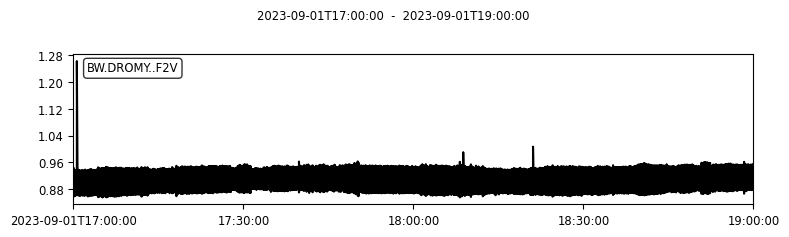

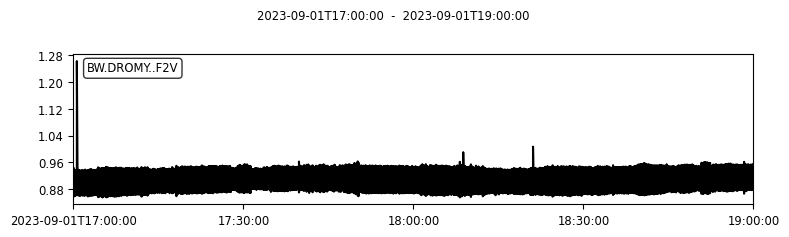

In [10]:
mon2.plot()

## Processing

In [11]:
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd
from acoustics.signal import phase_spectrum
from functions.get_time_intervals import __get_time_intervals

In [12]:
def __get_values(ff, psd, ph, f_sagn):

    from numpy import argmax, sqrt, where, argmin, gradient, mean
    from acoustics.signal import phase_spectrum

    ## specify f-band around Sagnac frequency
    fl = f_sagn - 2
    fu = f_sagn + 2

    ## get index of Sagnac peak
    idx_fs = where(psd == max(psd[(ff > fl) & (ff < fu)]))[0][0]

    ## estimate Sagnac frequency
    f_sagn_est = ff[idx_fs]

    ## estimate AC value at Sagnac peak
    # AC_est = max(psd[(ff > fl) & (ff < fu)])
    AC_est = psd[idx_fs]

    ## estimate DC value at ff = 0
    # DC_est = psd[0] / 2  ## half because spectrum had been amplitude corrected which is not true for DC?!
    DC_est = psd[0]

    ## estimate phase at Sagnac peak
    phase_est = ph[idx_fs] ## select phase of Sagnac

    # return f_sagn_est, sqrt(AC_est), sqrt(DC_est), phase_est
    return f_sagn_est, AC_est, DC_est, phase_est

In [13]:
def __get_fft(signal_in, dt, window=None):

    '''
    Calculating a simple 1D FastFourierSpectrum of a time series.

    RETURN:

    frequencies, spectrum, phase

    TEST:

    >>> spectrum, frequencies, phase = __fft(signal_in, dt ,window=None,normalize=None)
    '''

    from scipy.fft import fft, fftfreq, fftshift
    from scipy import signal
    from numpy import angle, imag

    ## determine length of the input time series
    n = int(len(signal_in))


    ## calculate spectrum (with or without window function applied to time series)
    if window:
        win = signal.get_window(window, n);
        spectrum = fft(signal_in * win, norm="ortho")

    else:
        spectrum = fft(signal_in, norm="ortho")

    ## calculate frequency array
    frequencies = fftfreq(n, d=dt)

    ## correct amplitudes of spectrum
    magnitude = abs(spectrum) * 2.0 / n
    # magnitude = abs(spectrum) / n

    phase = angle(spectrum, deg=False)
    # phase = imag(spectrum)

    ## return the positive frequencies
    return frequencies[0:n//2], magnitude[0:n//2], phase[0:n//2]

In [14]:
def __welch_psd(arr, dt, twin_sec=60):

    from scipy.signal import welch
    from scipy.signal.windows import hann

    nblock = int(1/dt * twin_sec)
    overlap = int(0.5*nblock)
    win = hann(nblock, True)

    ff, Pxx = welch(arr,
                    fs=1/dt,
                    window=win, noverlap=overlap,
                    nfft=nblock,
                    scaling="spectrum",
                    return_onesided=True)

    return ff, Pxx

In [134]:
def __hilbert_frequency_estimator(st, nominal_sagnac, fband):

    from scipy.signal import hilbert
    import numpy as np

    st0 = st.copy()

    ## extract sampling rate
    df = st0[0].stats.sampling_rate

    ## define frequency band around Sagnac Frequency
    f_lower = nominal_sagnac - fband
    f_upper = nominal_sagnac + fband

    ## bandpass with butterworth around Sagnac Frequency
    st0.detrend("demean")
    st0.taper(0.01)
    st0.filter("bandpass", freqmin=f_lower, freqmax=f_upper, corners=8, zerophase=True)


    ## estimate instantaneous frequency with hilbert
    signal = st0[0].data

    analytic_signal = hilbert(signal)
    amplitude_envelope = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * df)

    ## cut first and last 5% (corrupted data)
    dd = int(0.05*len(instantaneous_frequency))
    insta_f_cut = instantaneous_frequency[dd:-dd]

    ## get times
    t = st0[0].times()
    t_center = t[int((len(t))/2)]

    ## averaging of frequencies
    insta_f_cut_mean = np.mean(insta_f_cut)
    # insta_f_cut_mean = np.median(insta_f_cut)

    return t_center, insta_f_cut_mean

In [281]:
def __get_fft_values(signal_in, dt, f_sagn, window=None):

    from numpy import argmax, sqrt, where, argmin, gradient, mean
    from scipy.fft import fft, fftfreq, fftshift
    from scipy import signal
    from numpy import angle, imag, unwrap

    ## determine length of the input time series
    n = int(len(signal_in))

    signal_in = fftshift(signal_in)

    ## calculate spectrum (with or without window function applied to time series)
    if window:
        win = signal.get_window(window, n);
        spectrum = fft(signal_in * win, norm="forward")

    else:
        spectrum = fft(signal_in, norm="forward")

    ## calculate frequency array
    frequencies = fftfreq(n, d=dt)

    ## correct amplitudes of spectrum
    magnitude_corrected = abs(spectrum) *2 /n

    ## none corrected magnitudes
    magnitude = abs(spectrum)

    ## phase spectrum
    phase = angle(spectrum, deg=False)


    freq = frequencies[0:n//2]
    spec = magnitude[0:n//2]
    pha = phase[0:n//2]


    ## specify f-band around Sagnac frequency
    fl = f_sagn - 2
    fu = f_sagn + 2

    ## get index of Sagnac peak
    idx_fs = where(spec == max(spec[(freq > fl) & (freq < fu)]))[0][0]

    ## estimate Sagnac frequency
    f_sagn_est = freq[idx_fs]

    ## estimate AC value at Sagnac peak
    AC_est = spec[idx_fs] * 2

    ## estimate DC value at ff = 0
    DC_est = spec[0]

    ## estimate phase at Sagnac peak
    phase_est = pha[idx_fs] ## select phase of Sagnac

    return f_sagn_est, AC_est, DC_est, phase_est

## Configurations

In [282]:
tbeg, tend = sagn[0].stats.starttime, sagn[0].stats.endtime

interval = 60 ## seconds

fs0 = 303.05

fband = 30 ## Hz (+-)

method = "fft" ## welch | multitaper | fft

times = __get_time_intervals(tbeg, tend, interval_seconds=interval, interval_overlap=0)

## Computing

In [266]:
fs, ac, dc, ph = np.ones(len(times))*np.nan, np.ones(len(times))*np.nan, np.ones(len(times))*np.nan, np.ones(len(times))*np.nan


out_df = DataFrame()
out_df['time1'] = list(zip(*times))[0]
out_df['time2'] = list(zip(*times))[1]

for _k, _st in enumerate([sagn, mon1, mon2]):

    print(_k, "...")

    for _n, (t1, t2) in enumerate(times):

        _dat = _st.copy().trim(t1, t2)

#         f, psd, pha = __get_fft(_dat[0].data, _dat[0].stats.delta, window=None)

#         fs[_n], ac[_n], dc[_n], ph[_n] = __get_values(f, psd, pha, fs0)

        fs[_n], ac[_n], dc[_n], ph[_n] = __get_fft_values(_dat[0].data, _dat[0].stats.delta, fs0)

        t, fs[_n] = __hilbert_frequency_estimator(_dat, nominal_sagnac=fs0, fband=fband)

        # dc[_n] = np.mean(_dat)

    ph = np.unwrap(ph)

    if _k == 0:
        out_df['fj_fs'], out_df['fj_ac'], out_df['fj_dc'], out_df['fj_ph'] = fs, ac, dc, ph
    elif _k == 1:
        out_df['f1_fs'], out_df['f1_ac'], out_df['f1_dc'], out_df['f1_ph'] = fs, ac, dc, ph
    elif _k == 2:
        out_df['f2_fs'], out_df['f2_ac'], out_df['f2_dc'], out_df['f2_ph'] = fs, ac, dc, ph

## store data
date_str = f"{config['tbeg'].year}{str(config['tbeg'].month).rjust(2,'0')}{str(config['tbeg'].day).rjust(2,'0')}"
out_df.to_pickle(config['path_to_data']+f"{date_str}_{method}.pkl")
print(f" -> writing: {config['path_to_data']}{date_str}_{method}.pkl")


0 ...
1 ...
2 ...
 -> writing: /home/andbro/kilauea-data/sagnac_frequency/data/20230901_fft.pkl


In [267]:
# out_df = read_pickle(config['path_to_data']+f"20230919_backscatter.pkl")
# out_df = read_pickle(config['path_to_data']+f"20230901_backscatter.pkl")

In [268]:
out_df

,time1,time2,fj_fs,fj_ac,fj_dc,fj_ph,f1_fs,f1_ac,f1_dc,f1_ph,f2_fs,f2_ac,f2_dc,f2_ph
0,2023-09-01T17:00:00.000000Z,2023-09-01T17:01:00.000000Z,303.019543,0.175600,0.378175,-1.537000,303.019439,0.013530,0.738066,0.603003,303.018793,0.005236,0.898122,2.107132
1,2023-09-01T17:01:00.000000Z,2023-09-01T17:02:00.000000Z,303.019541,0.138314,0.378301,-2.282817,303.019368,0.010920,0.738098,-0.180774,303.019288,0.004230,0.898233,1.326334
2,2023-09-01T17:02:00.000000Z,2023-09-01T17:03:00.000000Z,303.019116,0.149946,0.378463,-1.262177,303.018952,0.011648,0.738096,0.791230,303.019174,0.004517,0.898584,2.300952
3,2023-09-01T17:03:00.000000Z,2023-09-01T17:04:00.000000Z,303.018825,0.156056,0.378545,-0.404525,303.018734,0.012072,0.737986,1.607973,303.018696,0.004691,0.899007,3.122102
4,2023-09-01T17:04:00.000000Z,2023-09-01T17:05:00.000000Z,303.018767,0.158360,0.378638,0.401877,303.018713,0.012177,0.737859,2.358312,303.018311,0.004781,0.899343,3.874129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2023-09-01T18:55:00.000000Z,2023-09-01T18:56:00.000000Z,303.010062,0.167061,0.382425,-73.435946,303.009917,0.010594,0.739386,-78.108081,303.009930,0.005867,0.913979,-76.793212
116,2023-09-01T18:56:00.000000Z,2023-09-01T18:57:00.000000Z,303.009867,0.169577,0.382523,-75.959519,303.009757,0.010714,0.739366,-80.690684,303.009519,0.005953,0.914231,-79.371537
117,2023-09-01T18:57:00.000000Z,2023-09-01T18:58:00.000000Z,303.009705,0.174047,0.382665,-78.556482,303.009551,0.010913,0.739422,-83.343458,303.009579,0.006081,0.914560,-82.027006
118,2023-09-01T18:58:00.000000Z,2023-09-01T18:59:00.000000Z,303.009521,0.176073,0.382805,-81.223480,303.009384,0.011010,0.739482,-86.062143,303.009057,0.006143,0.914798,-84.750932


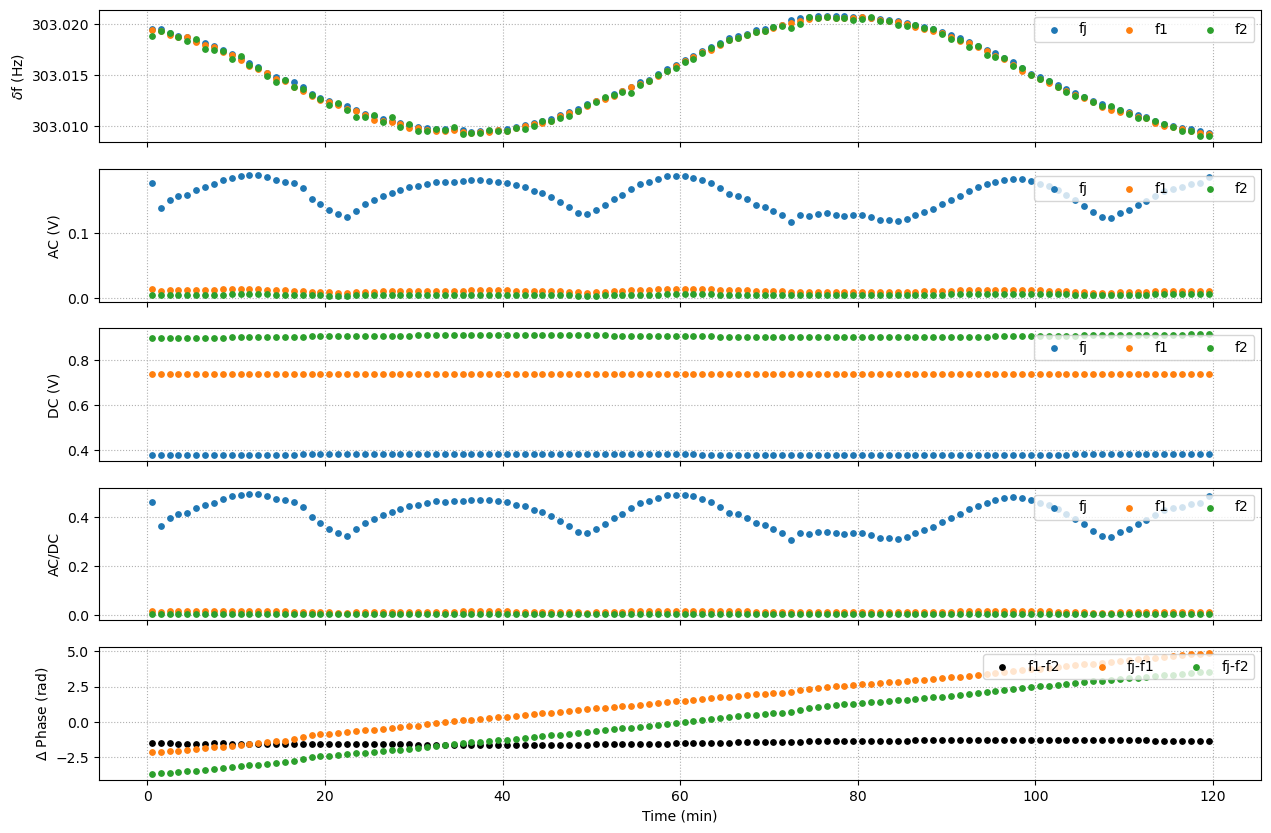

In [274]:
def __makeplot(df):

    Nrow, Ncol = 5, 1

    font = 12
    ms = 15

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    t_axis = (np.array(range(len(df['fj_fs'])))+0.5)*interval/60

    ax[0].scatter(t_axis, df['fj_fs'], zorder=2, s=ms, label="fj")
    ax[0].scatter(t_axis, df['f1_fs'], zorder=2, s=ms, label="f1")
    ax[0].scatter(t_axis, df['f2_fs'], zorder=2, s=ms, label="f2")
    ax[0].set_ylabel("$\delta$f (Hz)")
    ax[0].ticklabel_format(useOffset=False)

    ax[1].scatter(t_axis, df['fj_ac'], zorder=2, s=ms, label="fj")
    ax[1].scatter(t_axis, df['f1_ac'], zorder=2, s=ms, label="f1")
    ax[1].scatter(t_axis, df['f2_ac'], zorder=2, s=ms, label="f2")
    # ax[1].set_ylabel("AC (V / $\sqrt{Hz})$")
    ax[1].set_ylabel("AC (V)")

    ax[2].scatter(t_axis, df['fj_dc'], zorder=2, s=ms, label="fj")
    ax[2].scatter(t_axis, df['f1_dc'], zorder=2, s=ms, label="f1")
    ax[2].scatter(t_axis, df['f2_dc'], zorder=2, s=ms, label="f2")
    # ax[2].set_ylabel("DC (V / $\sqrt{Hz})$")
    ax[2].set_ylabel("DC (V)")
    # ax[2].set_yscale("log")

    ax[3].scatter(t_axis, df['fj_ac']/df['fj_dc'], zorder=2, s=ms, label="fj")
    ax[3].scatter(t_axis, df['f1_ac']/df['f1_dc'], zorder=2, s=ms, label="f1")
    ax[3].scatter(t_axis, df['f2_ac']/df['f2_dc'], zorder=2, s=ms, label="f2")
    # ax[3].set_yscale("log")
    ax[3].set_ylabel("AC/DC")

    ax[4].scatter(t_axis, df['f1_ph']-df['f2_ph'], color="k", zorder=2, s=ms, label="f1-f2")
    ax[4].scatter(t_axis, df['fj_ph']-df['f1_ph'], color="tab:orange", zorder=2, s=ms, label="fj-f1")
    ax[4].scatter(t_axis, df['fj_ph']-df['f2_ph'], color="tab:green", zorder=2, s=ms, label="fj-f2")
    ax[4].set_ylabel("$\Delta$ Phase (rad)")
    # ax[4].set_yscale("log")

    ax[4].set_xlabel("Time (min)")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1, ncol=3)

    plt.show();
    return fig

fig = __makeplot(out_df);

# fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_{method}_values_10hr.jpeg", format="jpeg", dpi=200, bbox_inches='tight')


## Beat Data

In [275]:
def __load_beat(tbeg, tend, ring, path_to_data):

    from datetime import date
    from pandas import read_pickle, concat, DataFrame, date_range
    from obspy import UTCDateTime


    tbeg, tend = UTCDateTime(tbeg), UTCDateTime(tend)

    dd1 = date.fromisoformat(str(tbeg.date))
    dd2 = date.fromisoformat(str(tend.date))

    year = str(tbeg.year)

    df = DataFrame()
    for dat in date_range(dd1, dd2):
        file = f"{year}/R{ring}/FJ{ring}_"+str(dat)[:10].replace("-", "")+".pkl"
        try:
            df0 = read_pickle(path_to_data+file)
            df = concat([df, df0])
        except:
            print(f"error for {file}")

    ## trim to defined times
    df = df[(df.times_utc >= tbeg) & (df.times_utc < tend)]

    ## correct seconds
    df['times_utc_sec'] = [abs(tbeg - UTCDateTime(_t))  for _t in df['times_utc']]

    return df

In [276]:
t1, t2 = UTCDateTime(out_df['time1'][0]), UTCDateTime(out_df['time1'][0])+len(out_df['time1'])*interval

# data = __load_beat(t1, t2, config['seed'].split(".")[3][2], config['path_to_autodata'])
# w_obs = data['fj']

## Define Quantities for Backscatter Correction

In [277]:
def __backscatter_correction(m01, m02, phase0, w_obs, nominal_sagnac, cm_filter_factor=1.033):

    ## Correct for bias
    m1 = m01 * ( 1 + m01**2 / 4 )
    m2 = m02 * ( 1 + m02**2 / 4 )

    ## angular correction for phase
    phase = phase0 + 0.5 * m1 * m2 * np.sin( phase0 )

    ## compute squares of common-mode modulations
    m2c = ( m1**2 + m2**2 + 2*m1*m2*np.cos( phase ) ) / 4

    ## compute squares of differential-mode modulations
    m2d = ( m1**2 + m2**2 - 2*m1*m2*np.cos( phase ) ) / 4  ## different angle!

    ## correct m2c for gain saturation of a HeNe laser
    # m2c = m2c * ( 1 + ( beta + theta )**2 * fL**2 * I0**2 / ws**2 )
    m2c = m2c * cm_filter_factor

    ## compute backscatter correction factor
    M = m2c - m2d + 0.25 * m1**2 * m2**2 * np.sin(phase)**2

    ## correction term
    term = ( 4 + M ) / ( 4 - M )

    ## backscatter correction
    BScorrection = -1 * ( term - 1 ) * nominal_sagnac

    w_corrected = np.array(w_obs) + BScorrection

    return w_corrected

In [278]:
# fractional beat modulations
m01 = out_df.f1_ac / out_df.f1_dc
m02 = out_df.f2_ac / out_df.f2_dc


# phase difference
ph1 = out_df.f1_ph
ph2 = out_df.f2_ph
phase0 = ph2 - ph1

# beat signal observed
w_obs = out_df.fj_fs


## from Hurst 2014

cm_filter_factor = 1.033

## Load Data of Ulrich

In [279]:
col_names = ["time", "fj", "f1", "f2", "BS", "fj_corrected", "ph1", "ph2", "acdc_1", "acdc_2", "acdc_j"]

ulli = read_csv(data_path+"sagnac_frequency/data/backscatter/ROMY_U_BScorrection_Ulli.txt", delimiter="\t", names=col_names)

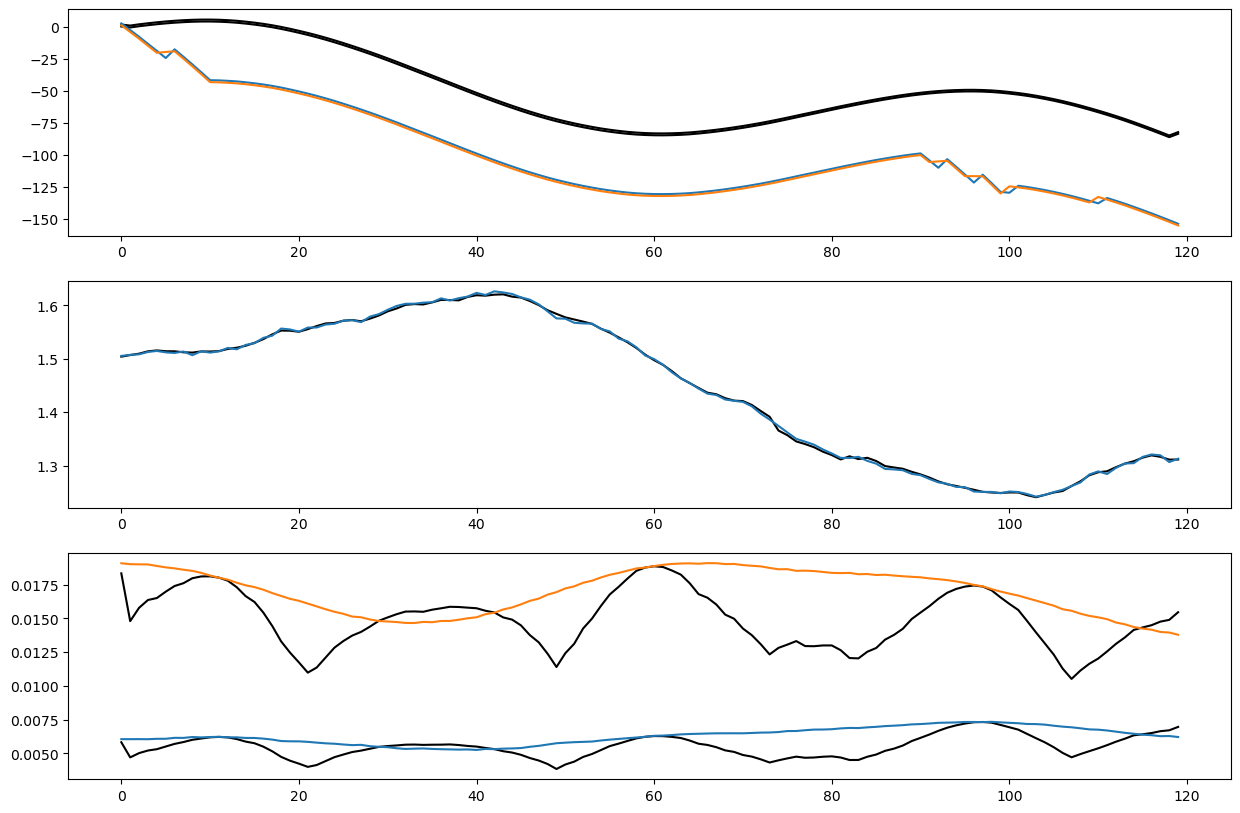

In [280]:
fig, ax = plt.subplots(3, 1, figsize=(15, 10))

ax[0].plot(ph1, "k")
ax[0].plot(ph2, "k")
ax[0].plot(ulli.ph1)
ax[0].plot(ulli.ph2)

ax[1].plot(phase0, "k")
ax[1].plot(np.unwrap(ulli.ph1 - ulli.ph2))

ax[2].plot(m01, color="k")
ax[2].plot(m02, color="k")

ax[2].plot(ulli.acdc_1)
ax[2].plot(ulli.acdc_2)

## Compute Backscatter Correction

In [256]:
w_corrected = __backscatter_correction(m01, m02, phase0, w_obs, fs0, cm_filter_factor=cm_filter_factor)

In [257]:
len(w_obs), len(w_corrected)

(120, 120)

In [258]:
# w_corrected = __backscatter_correction(ulli.acdc_1, ulli.acdc_2, ulli.ph1-ulli.ph2, ulli.fj, fs0, cm_filter_factor=cm_filter_factor)

## Plotting - Comparison

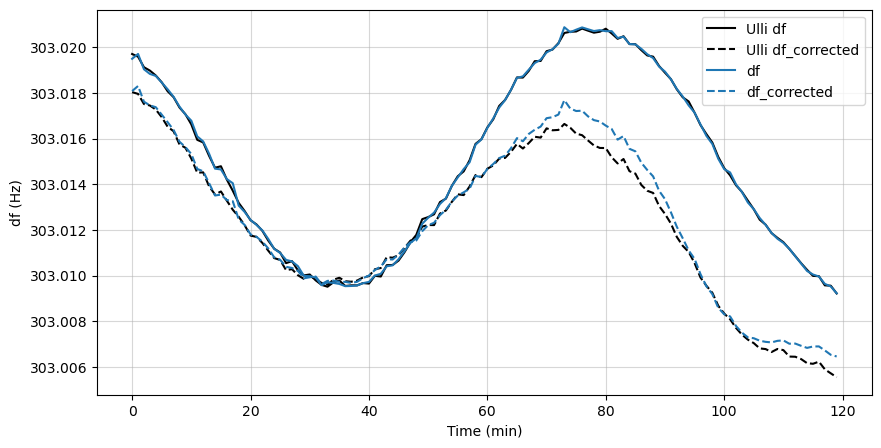

In [259]:
def __makeplot():

    fig = plt.figure(figsize=(10, 5))

    plt.plot(ulli.fj, label="Ulli df", color="k")
    plt.plot(ulli.fj_corrected, ls="--", label="Ulli df_corrected", color="k")

    plt.plot(w_obs, label="df", color="tab:blue")
    plt.plot(w_corrected, ls="--", label="df_corrected", color="tab:blue")

    plt.xlabel("Time (min)")
    plt.ylabel("df (Hz)")

    plt.ticklabel_format(useOffset=False)

    plt.grid(alpha=0.5)
    plt.legend()

    plt.show();

    return fig


fig = __makeplot()

# fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_compareUlli.png", format="png", dpi=200, bbox_inches='tight')


## Plotting

In [125]:

    ## Correct for bias
    m1 = m01 * ( 1 + m01**2 / 4 )
    m2 = m02 * ( 1 + m02**2 / 4 )

    ## angular correction for phase
    phase = phase0 + 0.5 * m1 * m2 * np.sin( phase0 )

    ## compute squares of common-mode modulations
    m2c = ( m1**2 + m2**2 + 2*m1*m2*np.cos( phase ) ) / 4

    ## compute squares of differential-mode modulations
    m2d = ( m1**2 + m2**2 - 2*m1*m2*np.cos( phase ) ) / 4  ## different angle!

    ## correct m2c for gain saturation of a HeNe laser
    # m2c = m2c * ( 1 + ( beta + theta )**2 * fL**2 * I0**2 / ws**2 )
    m2c = m2c * cm_filter_factor

    ## compute backscatter correction factor
    M = m2c - m2d + 0.25 * m1**2 * m2**2 * np.sin(phase)**2

    ## correction term
    term = ( 4 + M ) / ( 4 - M )

    ## backscatter correction
    correction = -1 * ( term -1 ) * 303.05

    w_corrected = np.array(w_obs) + correction

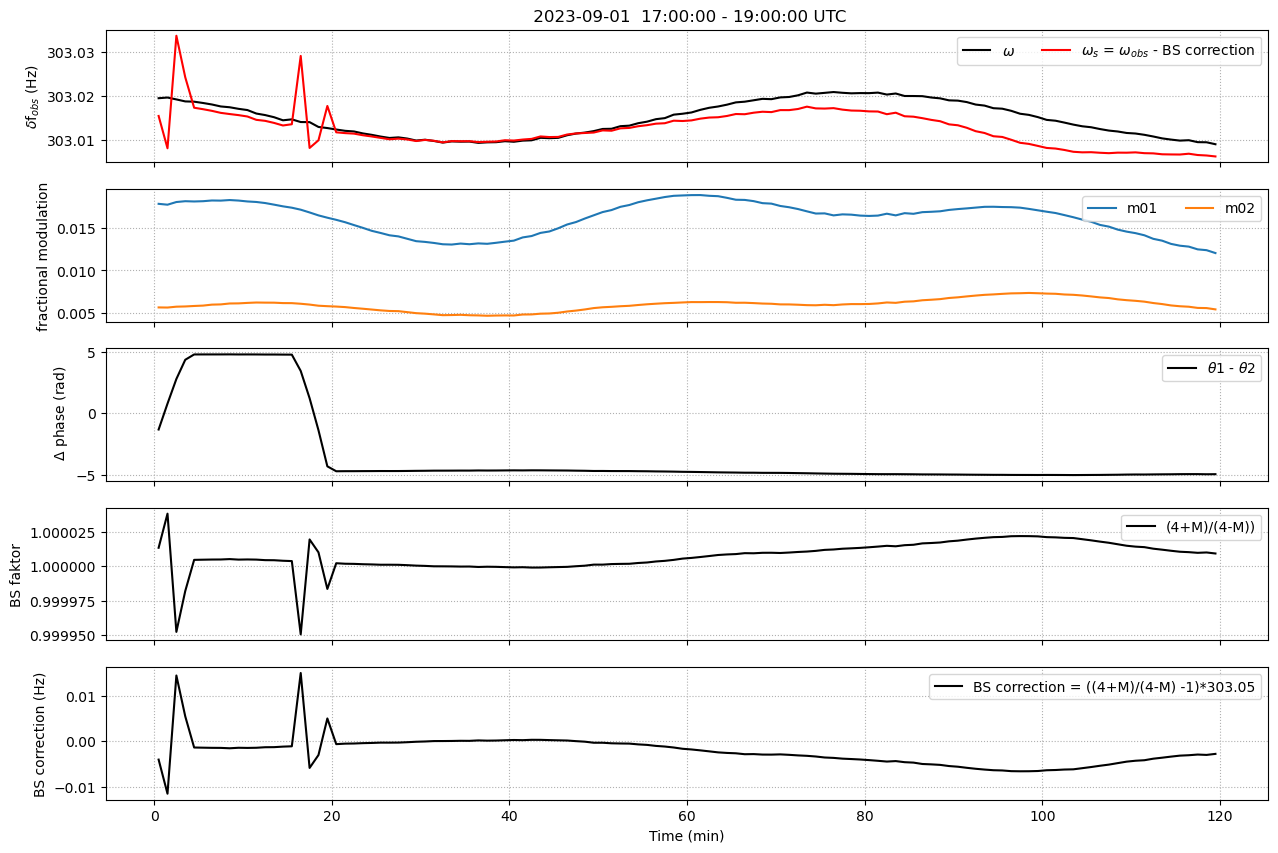

In [126]:
def __makeplot():

    Nrow, Ncol = 5, 1

    font = 12
    ms = 15

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    t_axis = (np.array(range(len(out_df['fj_fs'])))+0.5)*interval/60

    ax[0].plot(t_axis, w_obs, color="k", label="$\omega$")
    ax[0].plot(t_axis, w_corrected, color="r", label="$\omega_{s}$ = $\omega_{obs}$ - BS correction")
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\delta$f$_{obs}$ (Hz)")

    ax[1].plot(t_axis, m01, label="m01")
    ax[1].plot(t_axis, m02, label="m02")
    ax[1].set_ylabel("fractional modulation")

    ax[2].plot(t_axis, phase, color="k", label=r"$\theta$1 - $\theta$2")
    ax[2].set_ylabel(" $\Delta$ phase (rad)")

    # ax[3].plot(t_axis, M, color="k", label="M")
    ax[3].plot(t_axis, (4+M)/(4-M), color="k", label="(4+M)/(4-M))")
    ax[3].set_ylabel("BS faktor")
    ax[3].ticklabel_format(useOffset=False)

    ax[4].plot(t_axis, correction, color="k", label="BS correction = ((4+M)/(4-M) -1)*303.05")
    # ax[4].set_ylabel("$\delta$f$_{corrected}$ (Hz)")
    ax[4].set_ylabel("BS correction (Hz)")
    ax[4].ticklabel_format(useOffset=False)

    ax[4].set_xlabel("Time (min)")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1, ncol=3)

    ax[0].set_title(f" {t1.date}  {str(t1.time).split('.')[0]} - {str(t2.time).split('.')[0]} UTC")

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_frequencyomain_{method}_{interval}_{str(t1.date).replace('-',' ')}.png", format="png", dpi=200, bbox_inches='tight')

In [ ]:
omega = np.pi*2/86400

S = np.sqrt(3)/3*12/632.8e-9

lat = 48.162941

In [ ]:
S*omega*np.sin(np.deg2rad(lat)+np.deg2rad(109.5))

In [ ]:
S*omega*np.sin(np.deg2rad(lat))